Import Libraries

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


Load Dataset

In [30]:
# Load the dataset (Make sure the CSV file is in the same directory as the Jupyter notebook)
df = pd.read_csv("labeled_student_data_s.csv")
df = df[df['Interest Label'] != 'Exploring']
df.head()  # Display the first 5 rows

,Student ID,Operating System,DSA,Frontend,Backend,Machine Learning,Data Analytics,Project 1,Project 2,Project 3,Project 4,Interest Label
0,1,99,32,33,80,12,92,Robotics,Web Development,Data Science,Robotics,Robotics
1,2,7,21,39,54,20,39,Web Development,Web Development,Cybersecurity,Game Development,Web Development
2,3,51,23,85,8,17,93,Robotics,Robotics,AI,Machine Learning,Robotics
3,4,73,80,79,25,17,47,Machine Learning,Data Science,Robotics,Game Development,Game Development
4,5,30,6,86,55,91,85,Machine Learning,Web Development,Robotics,Robotics,Machine Learning


Define Subject and Project Columns

In [31]:
# Define subject and project columns
subject_cols = ['Operating System', 'DSA', 'Frontend', 'Backend', 'Machine Learning', 'Data Analytics']
project_cols = ['Project 1', 'Project 2', 'Project 3', 'Project 4']

Function to Label Student Interest

In [32]:
import pandas as pd
import numpy as np

# Ensure subject columns are numeric
df[subject_cols] = df[subject_cols].apply(pd.to_numeric, errors='coerce')

# Function to determine the student's interest
def determine_interest(row):
    # Select numeric values only
    top_subjects = row[subject_cols].astype(float).nlargest(3).index.tolist()  # Get top 3 subjects
    projects = row[project_cols].dropna().tolist()  # Get all projects (remove NaNs)
    
    for project in projects:
        if project in top_subjects:
            return project  # Assign domain directly if a project matches a strong subject
    
    return np.random.choice(projects) if projects else "Exploring"  # Handle empty projects

# Apply the function to label the dataset
df['Interest Label'] = df.apply(determine_interest, axis=1)
df.head()

,Student ID,Operating System,DSA,Frontend,Backend,Machine Learning,Data Analytics,Project 1,Project 2,Project 3,Project 4,Interest Label
0,1,99,32,33,80,12,92,Robotics,Web Development,Data Science,Robotics,Robotics
1,2,7,21,39,54,20,39,Web Development,Web Development,Cybersecurity,Game Development,Cybersecurity
2,3,51,23,85,8,17,93,Robotics,Robotics,AI,Machine Learning,AI
3,4,73,80,79,25,17,47,Machine Learning,Data Science,Robotics,Game Development,Machine Learning
4,5,30,6,86,55,91,85,Machine Learning,Web Development,Robotics,Robotics,Machine Learning


Encode Labels

In [33]:
# Encode categorical labels (interest domains)
label_encoder = LabelEncoder()
df['Interest Label Encoded'] = label_encoder.fit_transform(df['Interest Label'])
df[['Interest Label', 'Interest Label Encoded']].head()

,Interest Label,Interest Label Encoded
0,Robotics,5
1,Cybersecurity,1
2,AI,0
3,Machine Learning,4
4,Machine Learning,4


Define Features (X) and Target (y)

In [34]:
# Define input features and target
X = df[subject_cols]
y = df['Interest Label Encoded']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Apply SMOTE for Balancing Data

In [35]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
pd.Series(y_train_resampled).value_counts()

Interest Label Encoded
3    2417
5    2417
4    2417
1    2417
2    2417
0    2417
6    2417
Name: count, dtype: int64

Feature Scaling

In [36]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

Train XGBoost Model

In [37]:
# Initialize XGBoost model
xgb_model = XGBClassifier(n_estimators=1000, max_depth=6, learning_rate=0.5, random_state=42)

# Train the model
xgb_model.fit(X_train_scaled, y_train_resampled)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy After SMOTE:", accuracy_xgb)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy After SMOTE: 0.21536905965621841

Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.16      0.16       237
           1       0.14      0.16      0.15       229
           2       0.14      0.14      0.14       222
           3       0.12      0.11      0.11       229
           4       0.42      0.39      0.41       604
           5       0.13      0.13      0.13       231
           6       0.11      0.12      0.11       226

    accuracy                           0.22      1978
   macro avg       0.17      0.17      0.17      1978
weighted avg       0.22      0.22      0.22      1978



Hyperparameter Tuning (GridSearchCV)

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Ensure y_train_resampled has more than 2 classes
num_classes = len(set(y_train_resampled))

xgb = XGBClassifier(
    objective="multi:softprob" if num_classes > 2 else "binary:logistic",  # Automatically choose objective
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'  # Log loss for multi-class classification
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1  # Use all available processors
)

# Fit the model
grid_search.fit(X_train_scaled, y_train_resampled)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Get the best model and test accuracy
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


KeyboardInterrupt: 

Train Stacking Model

In [28]:
# Stacking model with RandomForest and XGBoost
stack_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42))
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)
)

stack_model.fit(X_train_scaled, y_train_resampled)
y_pred_stack = stack_model.predict(X_test_scaled)

# Evaluate Stacking Model
print("Stacking Model Accuracy:", accuracy_score(y_test, y_pred_stack))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stack))

KeyboardInterrupt: 

Voting Classifier

In [12]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
svc = SVC(kernel='rbf', probability=True)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('svc', svc)],
    voting='soft'
)

voting_clf.fit(X_train_scaled, y_train_resampled)
print("Voting Classifier Accuracy:", voting_clf.score(X_test_scaled, y_test))

Voting Classifier Accuracy: 0.2675885737357424


Check Class Distribution After SMOTE

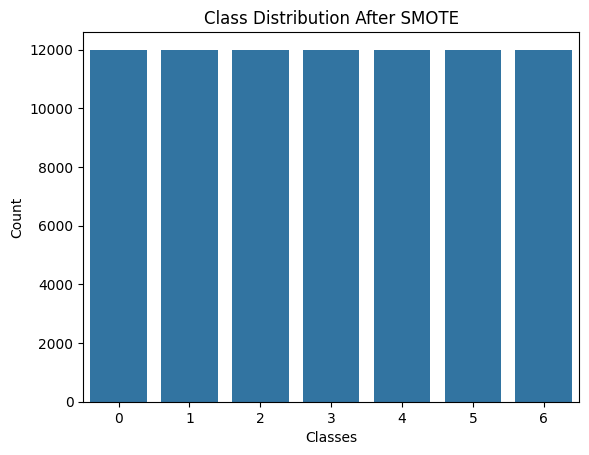

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

Check Feature Importance

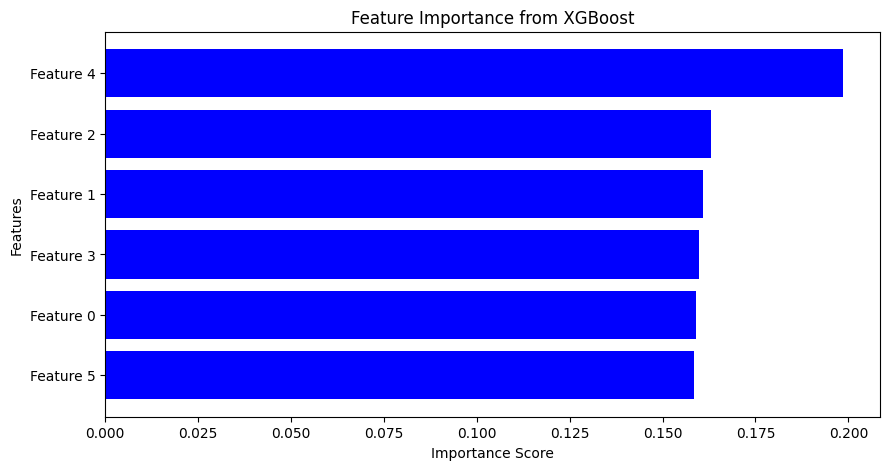

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# Train a basic XGBoost model
xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=42)
xgb_model.fit(X_train_scaled, y_train_resampled)

# Get feature importance
feature_importance = xgb_model.feature_importances_

# Create feature names dynamically
feature_names = [f"Feature {i}" for i in range(X_train_scaled.shape[1])]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="blue")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from XGBoost")
plt.gca().invert_yaxis()
plt.show()

Feature Engineering (Check Correlation)

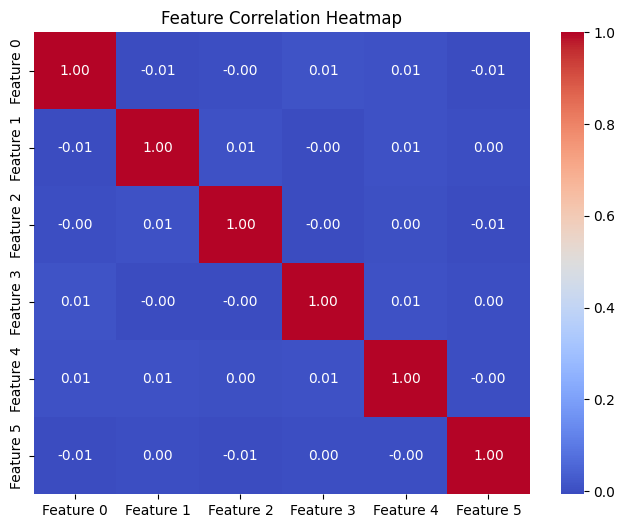

In [ ]:
import seaborn as sns

# Convert to DataFrame (if needed)
X_train_df = pd.DataFrame(X_train_scaled, columns=[f"Feature {i}" for i in range(X_train_scaled.shape[1])])

# Plot correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(X_train_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Feature Selection (Try Removing Features)

In [ ]:
X_train_selected = np.delete(X_train_scaled, [3], axis=1)  # Removing Feature 3
X_test_selected = np.delete(X_test_scaled, [3], axis=1)

xgb_model.fit(X_train_selected, y_train_resampled)
y_pred_selected = xgb_model.predict(X_test_selected)

accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f"Accuracy after feature removal: {accuracy_selected}")


Accuracy after feature removal: 0.22791965277076814


Try a Different Model (LightGBM)

In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(objective="multiclass", random_state=42)
lgb.fit(X_train_scaled, y_train_resampled)

y_pred_lgb = lgb.predict(X_test_scaled)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f"LightGBM Accuracy: {accuracy_lgb}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 83979, number of used features: 6
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
LightGBM Accuracy: 0.26153224992429597
